# Feature Selection

Now that we have a good amount of features that we can potentially use in our models, we should consciously think about which ones we want to keep and which ones to exclude. To help us with this process, we can perform correlation analysis.

## Correlation Analysis
### Dataset: 2023-24
We will use a full season's worth of data to perform correlation analysis.

In [7]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [2]:
# load in data
fe_23_24 = pd.read_csv('../data/processed/2023-24/feature_engineered_23_24.csv')

In [5]:
# all of our features currently (we might not want all of these to be included in the model)
fe_23_24.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28860 entries, 0 to 28859
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   element                  28860 non-null  int64  
 1   name                     28860 non-null  object 
 2   position                 28860 non-null  object 
 3   GW                       28860 non-null  int64  
 4   total_points             28860 non-null  int64  
 5   value                    28860 non-null  int64  
 6   minutes                  28860 non-null  int64  
 7   expected_goals           28860 non-null  float64
 8   expected_assists         28860 non-null  float64
 9   expected_goals_conceded  28860 non-null  float64
 10  goals_scored             28860 non-null  int64  
 11  assists                  28860 non-null  int64  
 12  goals_conceded           28860 non-null  int64  
 13  clean_sheets             28860 non-null  int64  
 14  ict_index             

### Visualizing Correlations
We will use ```seaborn``` and ```matplotlib``` to plot a correlation matrix between our (numerical) features and the target variable: ```total_points```.

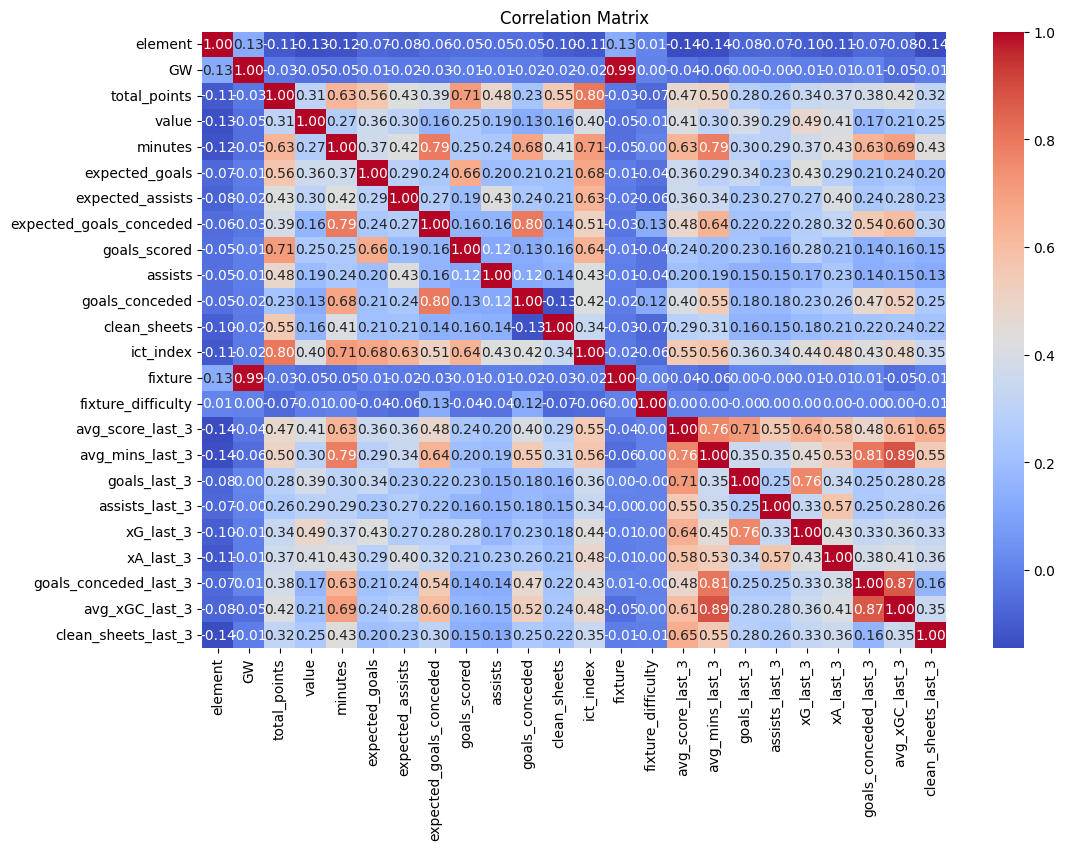

In [8]:
numeric_cols = fe_23_24.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = fe_23_24[numeric_cols].corr()

# plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix")
plt.show()

In [9]:
# as expected, the heatmap is very messy; now let's isolate and focus on each feature's correlation with 'total_points'
target_correlation = correlation_matrix['total_points'].sort_values(ascending=False)
print(target_correlation)

total_points               1.000000
ict_index                  0.802026
goals_scored               0.708795
minutes                    0.627946
expected_goals             0.563043
clean_sheets               0.549375
avg_mins_last_3            0.498350
assists                    0.480520
avg_score_last_3           0.468813
expected_assists           0.427027
avg_xGC_last_3             0.415173
expected_goals_conceded    0.389982
goals_conceded_last_3      0.380225
xA_last_3                  0.365354
xG_last_3                  0.341725
clean_sheets_last_3        0.316526
value                      0.307297
goals_last_3               0.282883
assists_last_3             0.255870
goals_conceded             0.226529
GW                        -0.027102
fixture                   -0.027556
fixture_difficulty        -0.067449
element                   -0.108135
Name: total_points, dtype: float64
